# BERTによるテキスト分類 (Banking77)
今回は，`banking77`というデータセットを用いて，金融ドメインにおける詳細テキスト分類タスクを行います．<br>
テキストを処理するモデルとしてBERTをベースとしたテキスト分類モデルを構築します．<br>
<br>
一般的に，transformerモデルは大規模な事前学習により性能を発揮すると言われており，<br>
BERTモデルにおいても大規模なデータセットで事前学習することで，文法や文脈の構成など自然言語における一般的な知識を獲得できます．<br>
事前学習で一般的な知識を獲得後，各タスクへの適応などをして応用・利用されています．<br>
<br>
本演習では，以下の2部構成となっております．<br>
1. **事前学習**
2. **下流タスクへのファインチューニング**

---
## 準備：モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1
! pip install -q torchinfo
# 提出用ツールのインストール
! pip install -q git+https://github.com/Taiga10969/dlcsubmissiontool.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import math
import os

from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm
from transformers import (BertConfig, BertForMaskedLM,
                          BertForSequenceClassification, BertTokenizerFast,
                          DataCollatorForLanguageModeling, Trainer,
                          TrainingArguments)

# GPUの利用確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Google Drive マウント & ワークスペース初期化
学習済みモデルなどの保存用に Google Drive を `/content/drive` にマウントし、作業ディレクトリを初期化します。

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

WORKSPACE_ROOT = Path("/content/drive/MyDrive/DLCompetition_03_BANKING77")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## モデルの基本設定
事前学習で使用するモデルと下流タスクで使用するモデルは，モデル構造に若干の違いがあります．<br>
両モデルとも共通して`BERT Encoder`を内部に持ちますが，それぞれ以下の違いがあります．
### `BertForMaskedLM`：事前学習用モデル
- **概要**
    - タスク名：Masked Language Modeling（マスク化言語モデル）
    - 目的： 一部のトークンを隠して（例: [MASK]）そのトークンを予測
- **出力**
    - BERTのエンコーダ出力の各トークンベクトルに対して，Headとして追加した線形層で語彙サイズ分の確率分布を出力
    - 出力次元：[batch_size, seq_length, vocab_size]

### `BertForSequenceClassification`：下流タスク（ファインチューニング）用モデル
- **概要**
    - タスク名：文分類（Text Classification）
    - 目的： 入力文（または文ペア）を，特定のクラスラベル（カテゴリ）に分類
- **出力**
    - BERTのエンコーダで `[CLS]` トークンに対応するベクトルを抽出し，Headとして追加した線形層（+Softmax）で分類スコアを出力
    - 出力次元：[batch_size, num_labels]

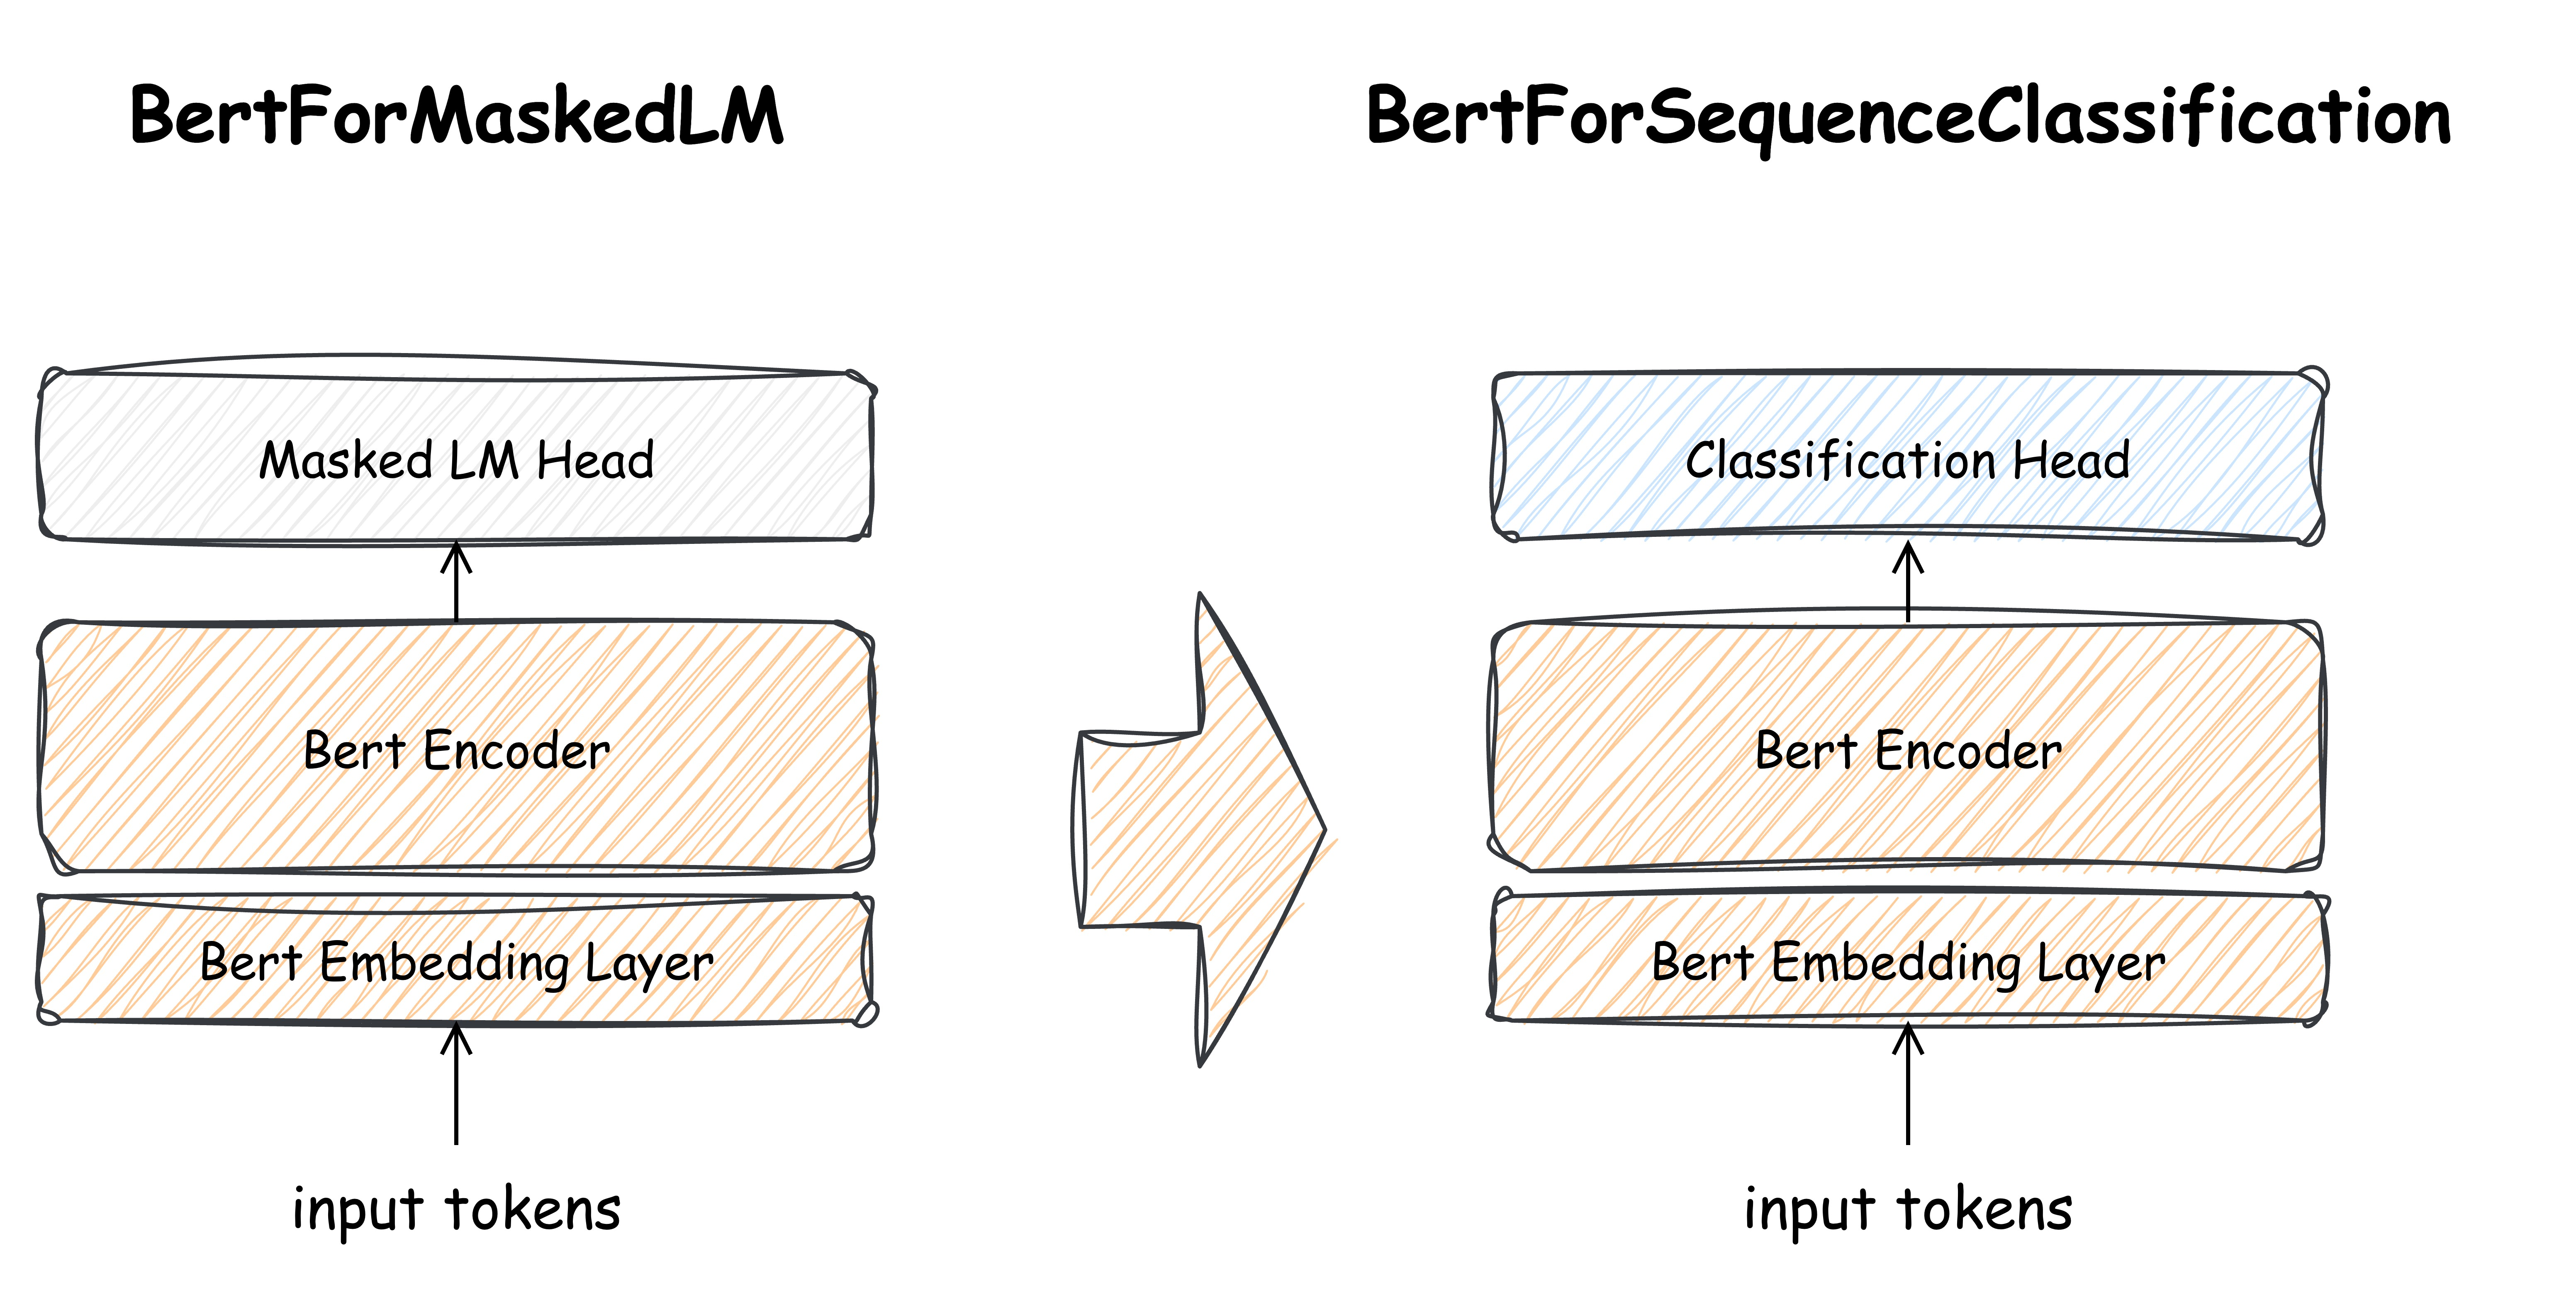

両モデルとも内部で共通して持つ **BERT Encoder** のパラメータを下流タスクへ引き継ぐことで，<br>
事前学習で獲得した一般的な知識を下流タスクでも利用できるようになります．<br>
<br>
本演習では，🤗Hugging Faceの `transformers` というライブラリ (準備でインポート済み) を用いてモデルを構築します．<br>
`transformers` とは，DeepLearning用のオープンソースフレームワークです．<br>
簡単にモデルの構築ができたり，最先端の事前トレーニング済みモデルをダウンロードできたり，簡単に学習できたりするツールが揃っています．

In [ ]:
# 既存BERTのトークナイザーを利用 （読み込み）
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
print("tokenizer.vocab_size : ", tokenizer.vocab_size) #読み込んだトークナイザーのボキャブラリ数の確認


# Transformer Encoder モデル (BERT) の設定を定義
config = BertConfig(
    vocab_size=tokenizer.vocab_size,      # トークナイザーのvocab_sizeを設定
    hidden_size=128,                      # モデルの隠れ層のユニット数
    num_hidden_layers=4,                  # モデルの隠れ層の数
    num_attention_heads=4,                # モデルの注意ヘッドの数
    intermediate_size=128,                # モデルの中間層のユニット数
    max_position_embeddings=256,          # モデルの最大位置埋め込み数
    pad_token_id=tokenizer.pad_token_id,  # モデルのパディングトークンのid
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer.vocab_size :  30522


In [ ]:
# トークナイズ関数の定義（データセットの前処理に使用します）
max_length = 256 # モデルの最大入力長
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],             # 入力カラム名（データセットにより "sentence" や "content" の場合も）
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_attention_mask=True
    )

In [ ]:
# 精度計算関数の定義　（推論結果の評価に使用します）
def accuracy_score(preds, labels):
    """
    シンプルな精度(Accuracy)計算関数．
    preds, labels は list, numpy, torch いずれでもOK．
    """
    # Tensor化してCPUに移動
    preds = torch.tensor(preds)
    labels = torch.tensor(labels)

    # サイズを合わせる（例：shapeが違う場合に備える）
    preds = preds.view(-1)
    labels = labels.view(-1)

    # 正解率を計算
    correct = (preds == labels).sum().item()
    total = len(labels)
    return correct / total if total > 0 else 0.0

---
## 1.事前学習
ここでは，BERTモデルを **Masked Language Model** (MLM)で事前学習を行います．<br>
MLMは，入力文の一部の単語を意図的にマスクし，その隠された単語が何であるかをモデルに予測させる学習手法です．<br>
これにより，文章の文法や表現方法などが学習できます．<br>

### MLMの学習の流れ
1. 文をトークン化（例：「今日は天気がいい」 → `[CLS] 今日 は 天気 が いい [SEP]`）
2. 一部の単語を `[MASK]` に置き換える（例：「今日は `[MASK]` がいい」）
3. モデルにこの文を入力し、マスクされた位置の単語を予測する（例：「`[MASK]` → 天気」）

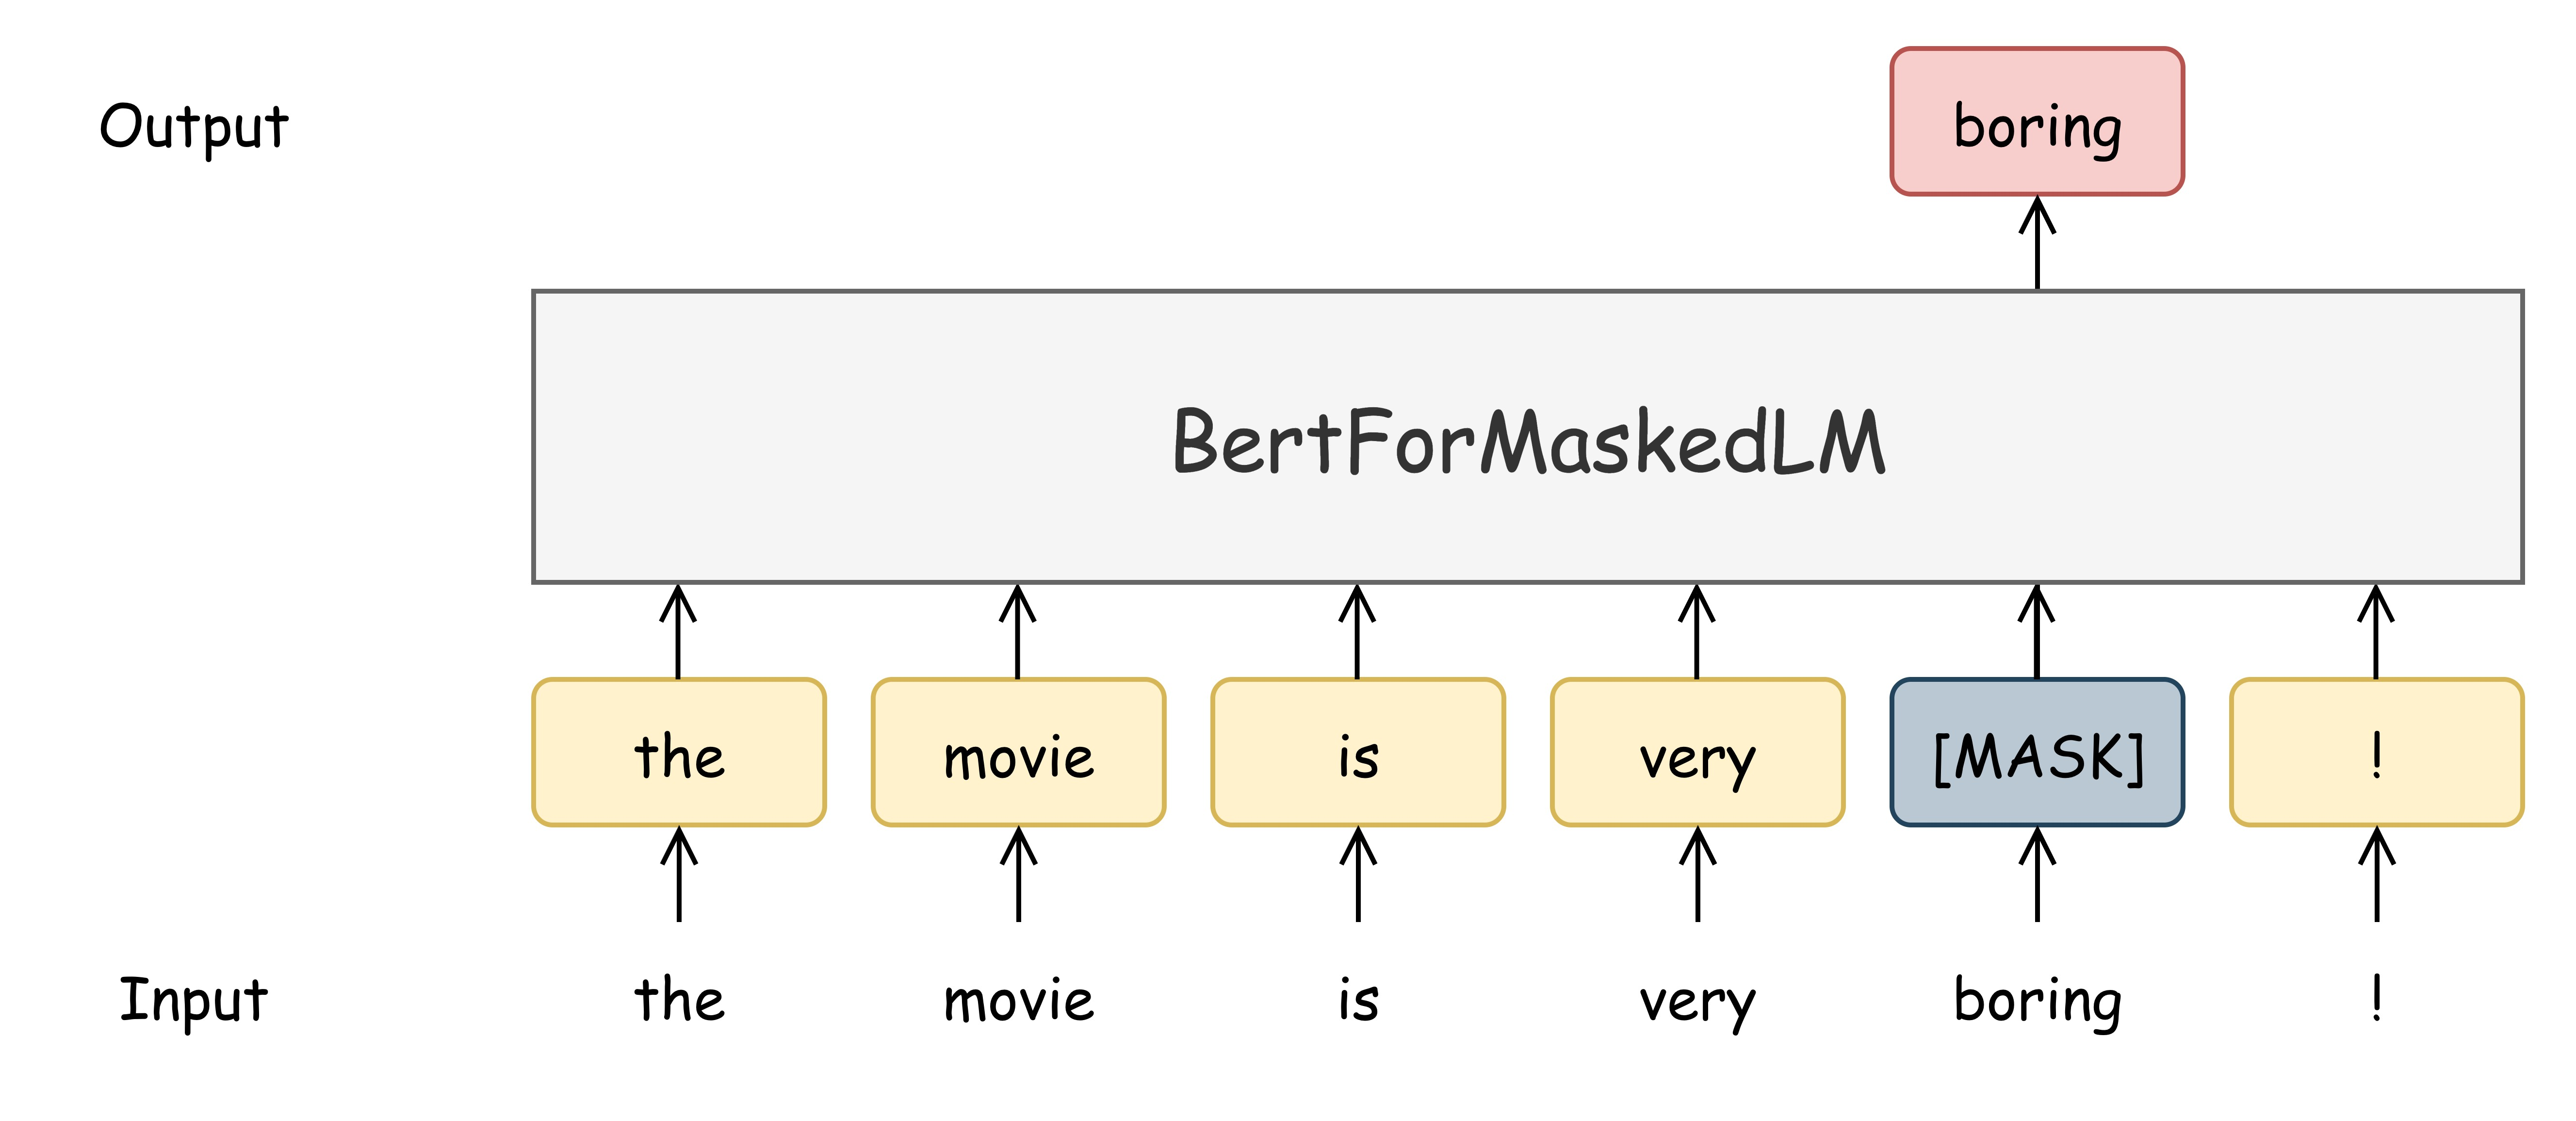

### 補足
事前学習手法は複数のタスクが提案されていますが，本演習では MLM を扱います．

### 注意
**既に事前学習したモデルの重みを持っている場合**や，<br>
**事前学習なしで，直接下流タスクに適応してみる**などの実験してみたい場合は，<br>
この事前学習のフェーズを飛ばして実行しても問題ありません！（2.下流タスクへのファインチューニングから再開してください）

In [ ]:
# 事前学習モデルの保存名と保存先を定義
pre_trained_model_name = "smallbert-mlm_ver_init"
pre_trained_model_path = os.path.join(WORKSPACE_ROOT, pre_trained_model_name)

# 既存チェック（ココでErrorが出た場合は，既に同じ名前のファイルが保存されています）
if os.path.exists(pre_trained_model_path):
    raise FileExistsError(f"保存先 {pre_trained_model_path} は既に存在します。別の名前を指定するか、フォルダを削除してください。")

In [ ]:
# 事前学習モデル(MLM用)の構築
model = BertForMaskedLM(config).to(device)
summary(model)

Layer (type:depth-idx)                                       Param #
BertForMaskedLM                                              --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   3,906,816
│    │    └─Embedding: 3-2                                   32,768
│    │    └─Embedding: 3-3                                   256
│    │    └─LayerNorm: 3-4                                   256
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  398,336
├─BertOnlyMLMHead: 1-2                                       --
│    └─BertLMPredictionHead: 2-3                             --
│    │    └─BertPredictionHeadTransform: 3-7                 16,768
│    │    └─Linear: 3-8                                      3,937,338
Total 

### 事前学習 (MLM) に用いるデータセット
MLM は，入力文の一部（例：15%程度の単語）を `[MASK]` トークンに置き換え，その隠された単語を予測させる **自己教師あり学習** (Self-supervised learning) の一種です．<br>
そのため，クラス分類のようなラベルが必要なく，入力文そのものから教師信号を作り出します．<br>
<br>
先ほどは，🤗Hugging Faceの `transformers` というライブラリを用いてモデルを構築しましたが，<br>
今回は，🤗Hugging Faceの `datasets` というライブラリを用いてデータをロードして前処理を行います．<br>

#### ・データのロード
今回は，**WikiText** というデータセットを利用します．
`wikitext-2-raw-v1` は，BERT や GPT など多くの言語モデルの事前学習や評価によく使われる有名な英語テキストデータセットです．<br>
**WikiText** は，英語版 Wikipedia の中でも「高品質な記事（Featured Articles）」のみを抽出したテキストデータセットです．
| バージョン            | 概要        | トークン数（おおよそ） |
| ---------------- | --------- | ----------- |
| **WikiText-2**　（今回使用）   | 小規模・実験用   | 約2百万語       |
| **WikiText-103** | 大規模・本格学習用 | 約1億語        |


#### ・前処理：`.map()` の役割
`.map()` は データ変換 を行うメソッドです．各サンプルに対して任意の関数（ここでは `tokenize_fn`）を適用します．<br>
`tokenize_fn`は準備で定義済みですが，各サンプルに tokenizer を適用してトークンID列を作成する関数になっています．<br>
この処理によって，次のような形式にデータセットが変換されます．
```python
{
  "input_ids": [101, 2004, 2051, 102, 0, 0, ...],
  "attention_mask": [1, 1, 1, 1, 0, 0, ...]
}
```
#### ・前処理：`.set_format()` の役割
`.set_format()` は データの型変換と出力形式の指定を行う関数です．<br>
Hugging Face のデータセットはもともと Python の辞書のような構造を持っていますが，<br>
`.set_format()` により PyTorch/TensorFlow/JAX 向けに変換して扱いやすくします．今回はPyTorchで実装しますので `type="torch"` を指定して処理します．<br>
これにより，後続の学習用の関数に利用できるようになります．

In [ ]:
wikitext_datasets = load_dataset("wikitext", "wikitext-2-raw-v1")
wikitext_datasets = wikitext_datasets.map(tokenize_fn, batched=True, remove_columns=["text"])
wikitext_datasets.set_format(
    type="torch",
    columns=["input_ids", "attention_mask"]
)

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

### Trainer による事前学習 (MLM)
ここでは，🤗Hugging Faceの `transformers` というライブラリの中の **Trainer** という機能を使って，簡単にモデルの学習ができます．<br>
**Trainer** を利用するための準備 ~ 実際に学習するところまでを実装します．<br>

#### ・`DataCollatorForLanguageModeling`のインスタンス化
**DataCollator** は「ミニバッチ単位の前処理を担当するクラス」です．<br>
ここで使用している `DataCollatorForLanguageModeling` は，MLM 用の特別なコレクタになっています．

#### ・`TrainingArguments`の設定
`TrainingArguments` は **Trainer** に渡す学習ハイパーパラメータや出力設定をまとめたクラスです．<br>
主なパラメータの意味は以下のとおりです．
| パラメータ                | 説明                                                  |
| -------------------- | --------------------------------------------------- |
| **output_dir**       | モデルやログを保存するディレクトリ．学習後に `pytorch_model.bin` が出力されます． |
| **learning_rate**    | 学習率．BERTなどの微調整では一般的に `5e-5`〜`3e-5` が使われます．          |
| **num_train_epochs** | 学習の繰り返し回数．10は小規模データセットには妥当です．                       |
| **weight_decay**     | 大きな重みを抑制して過学習を防ぐための正則化．                             |
| **warmup_ratio**     | 学習初期に学習率を徐々に上げて安定させる設定．                             |
| **max_grad_norm**    | 勾配の上限値を設定して勾配爆発を防止します．                              |
| **logging_steps**    | トレーニングログを出力するステップ間隔．                                |
| **save_steps**       | モデルを保存するステップ間隔．                                     |
| **save_total_limit** | 保存するチェックポイント数の上限．古いものは自動で削除されます．                    |

#### ・`Trainer` の作成と学習
Trainerは以下を自動的に行うことができます．（学習ループのプログラムを書く必要なし）<br>
1. ミニバッチの作成
2. 順伝播 (forward)
3. 損失計算
4. 逆伝播 (backward)
5. 検証と保存

`trainer`を作成後に
```python
trainer.train()
```
を呼び出すだけで，自動的に学習が開始されます．

In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,             # マスク付けを行うかどうか
    mlm_probability=0.15  # マスク付けを行う確率
)

# 学習設定の定義
training_args = TrainingArguments(
    output_dir="./smallbert-mlm-training_log",      # 学習途中のログ保存先
    per_device_train_batch_size=16,    # 1GPUあたりのバッチサイズ
    learning_rate=5e-5,                # 学習率
    num_train_epochs=10,               # 学習エポック数
    weight_decay=0.01,                 # 重み減衰（L2正則化）
    warmup_ratio=0.1,                  # 学習率ウォームアップ比率
    max_grad_norm=1.0,                 # 勾配クリッピング（勾配爆発防止）
    logging_steps=100,                 # ログ出力の頻度
    save_steps=500,                    # モデル保存間隔
    save_total_limit=2,                # 保存するチェックポイント数の上限
    report_to="none",                  # TensorBoardなどへのレポートを無効化
)


# Trainerオブジェクトの作成
# Trainer：モデルの学習や評価を行うためのオブジェクト
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=wikitext_datasets["train"],
    eval_dataset=wikitext_datasets["validation"],
    data_collator=data_collator,
)

# 学習
trainer.train()

Step,Training Loss
100,10.307000
200,10.277800
300,10.217800
400,10.128900
500,10.002900
600,9.845800
700,9.667700
800,9.492900
900,9.303300
1000,9.119200


TrainOutput(global_step=22950, training_loss=7.090794831984443, metrics={'train_runtime': 1844.5114, 'train_samples_per_second': 199.066, 'train_steps_per_second': 12.442, 'total_flos': 251472311439360.0, 'train_loss': 7.090794831984443, 'epoch': 10.0})

### 学習済みのモデルを保存
MLMで学習を終えた BERT モデルと，その対応する トークナイザ を保存します．<br>
保存しておくことで，あとで簡単に再利用できるようになります<br>（下流タスクパートで重みのディレクトリがあれば実行されるようになっています）：

In [ ]:
# モデルとトークナイザを保存
model.eval()
trainer.save_model(pre_trained_model_path)
tokenizer.save_pretrained(pre_trained_model_path)

('/content/drive/MyDrive/DLCompetition_03_BANKING77/smallbert-mlm_ver_init/tokenizer_config.json',
 '/content/drive/MyDrive/DLCompetition_03_BANKING77/smallbert-mlm_ver_init/special_tokens_map.json',
 '/content/drive/MyDrive/DLCompetition_03_BANKING77/smallbert-mlm_ver_init/vocab.txt',
 '/content/drive/MyDrive/DLCompetition_03_BANKING77/smallbert-mlm_ver_init/added_tokens.json',
 '/content/drive/MyDrive/DLCompetition_03_BANKING77/smallbert-mlm_ver_init/tokenizer.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
## 2.下流タスクへのファインチューニング
ここでは，今回の演習で目指す **金融ドメインにおける詳細テキスト分類タスク** に適応させるようにモデルを学習します．<br>
事前学習では，🤗Hugging Faceの `transformers` というライブラリの中の **Trainer** という機能を使って，簡単にモデルの学習をしました．<br>
下流タスクへのファインチューニングで部分では，言語モデルの学習プロセスを学ぶことも目的として学習ループを実装します．

### 下事前学習モデルと下流タスクモデルの違い
事前学習と下流タスク用のモデルはモデル構造に違いがあります．
| モデル種別                                     | 出力の目的         | ヘッドの構造（最上層）                                  |
| ----------------------------------------- | ------------- | -------------------------------------------- |
| **BertForMaskedLM**（事前学習用）                | マスクされた単語を予測する | トークン単位（単語ごと）に確率分布を出す “言語モデルヘッド”              |
| **BertForSequenceClassification**（下流タスク用） | 入力文全体を分類する    | `[CLS]` トークンから文全体の表現を取得し，線形層でクラス分類する “分類ヘッド” |

そこで，BERT本体の重み（Transformerエンコーダ部分）は再利用できますが，出力部（ヘッド）はタスクの種類に合わせて構造を切り替える必要があります．

### 下流タスク用モデルの構築
以下のコードでは，事前学習済みの重みがあるかどうかで処理を分岐しています．<br>
事前学習の重みがない場合は，ランダムな重みで初期化されたモデルを構築します．

In [ ]:
# 事前学習済みの重みの有無によって，下流タスク用のモデルを構築方法を変えています．

# 事前学習済みの重みのディレクトリ名（適宜変更）
pre_trained_model_name = "smallbert-mlm_ver_init"
pre_trained_model_path = os.path.join(WORKSPACE_ROOT, pre_trained_model_name)

if os.path.exists(pre_trained_model_path):
    # 事前学習済みの重みが存在する場合は，その重みを用いて下流タスク用のモデルを構築します．
    model = BertForSequenceClassification.from_pretrained(pre_trained_model_path, num_labels=77)
    tokenizer = BertTokenizerFast.from_pretrained(pre_trained_model_path)
    print("[info] 事前学習済みの重みを利用")
else:
    # 事前学習済みの重みが存在しない場合は，事前学習なしで直接下流タスク用のモデルを構築します．
    config.num_labels = 77
    model = BertForSequenceClassification(config).to(device)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    print("[info] 事前学習なし")

model = model.to(device)
summary(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/DLCompetition_03_BANKING77/smallbert-mlm_ver_init and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[info] 事前学習済みの重みを利用


Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   3,906,816
│    │    └─Embedding: 3-2                                   32,768
│    │    └─Embedding: 3-3                                   256
│    │    └─LayerNorm: 3-4                                   256
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  398,336
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      16,512
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─Linear: 1-3

### 下流タスク用データセット (baking77) の読み込み
ここでは，下流タスクで使用する `Banking77` データセットを読み込み，BERTモデルに入力できる形式へと整形する前処理を行います．<br>
`Banking77` は，銀行業務に関する英語のユーザー問い合わせ文を77種類の意図（intent）に分類したテキスト分類データセットです．

#### 前処理
`.map()` と `.set_format` の処理は事前学習部分と同様です．

#### DataLoader の作成
`DataLoader` はPyTorchの機能で，データセットからミニバッチを自動で取り出すためのクラスです．<br>
`shuffle=True` により，学習データを毎エポックごとにランダムに並べ替えて汎化性能を高めます．

In [ ]:
dataset = load_dataset("banking77")
print(dataset)

# トークナイズ
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
# データセットのフォーマットを変更
tokenized_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

# データローダーの作成
train_loader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True)
valid_loader = DataLoader(tokenized_dataset["test"], batch_size=64)

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

### 学習
下流タスクへ適応させるための教師あり学習を行う学習ループを実装します．<br>
注目すべき点としては，<br>
`criterion = nn.CrossEntropyLoss()`のように明示的な損失関数（criterion）を定義していないにもかかわらず，lossを獲得している点です．<br>
今回構築した，Hugging Faceの`BertForSequenceClassification`などの高レベルモデルは，**タスクごとに適切な損失関数を内部に組み込んでいます．**<br>
そのため，`forward()`メソッドに `labels` を入力すると，内部的に自動で損失を計算し，`outputs.loss` として返してくれます．<br>
**Sequence Classification タスク**における内部で使われている損失関数は`CrossEntropyLoss()`になっています．


In [ ]:
# 学習設定==============
num_epochs = 20
lr = 2e-5

optimizer = AdamW(model.parameters(), lr=lr)
# =====================


train_losses = []
valid_losses = []
acc_scores = []

for epoch in range(num_epochs):
    print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")

    # ---- 訓練フェーズ ----
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()

        # バッチをGPUへ転送
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # 順伝播
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        train_losses.append(loss.item())

        # 逆伝播
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # ---- 検証フェーズ ----
    model.eval()
    preds, trues = [], []
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            val_loss += loss.item()

            valid_losses.append(loss.item())

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    acc = accuracy_score(trues, preds)
    acc_scores.append(acc)
    print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {acc:.4f}")


===== Epoch 1/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 35.71it/s]


Train Loss: 4.3364


Validating: 100%|██████████| 49/49 [00:00<00:00, 58.16it/s]


Validation Loss: 4.3407 | Accuracy: 0.0133

===== Epoch 2/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.53it/s]


Train Loss: 4.3021


Validating: 100%|██████████| 49/49 [00:00<00:00, 62.03it/s]


Validation Loss: 4.2651 | Accuracy: 0.0318

===== Epoch 3/20 =====


Training: 100%|██████████| 313/313 [00:10<00:00, 31.08it/s]


Train Loss: 4.1729


Validating: 100%|██████████| 49/49 [00:00<00:00, 59.57it/s]


Validation Loss: 4.1043 | Accuracy: 0.0312

===== Epoch 4/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.73it/s]


Train Loss: 4.0019


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.75it/s]


Validation Loss: 3.9426 | Accuracy: 0.0403

===== Epoch 5/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.56it/s]


Train Loss: 3.8540


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.50it/s]


Validation Loss: 3.8172 | Accuracy: 0.0614

===== Epoch 6/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.53it/s]


Train Loss: 3.7308


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.35it/s]


Validation Loss: 3.7179 | Accuracy: 0.0714

===== Epoch 7/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.79it/s]


Train Loss: 3.6261


Validating: 100%|██████████| 49/49 [00:00<00:00, 57.10it/s]


Validation Loss: 3.6252 | Accuracy: 0.0838

===== Epoch 8/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.76it/s]


Train Loss: 3.5372


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.73it/s]


Validation Loss: 3.5438 | Accuracy: 0.1036

===== Epoch 9/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.69it/s]


Train Loss: 3.4549


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.30it/s]


Validation Loss: 3.4719 | Accuracy: 0.1195

===== Epoch 10/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.66it/s]


Train Loss: 3.3819


Validating: 100%|██████████| 49/49 [00:00<00:00, 59.07it/s]


Validation Loss: 3.4080 | Accuracy: 0.1409

===== Epoch 11/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.83it/s]


Train Loss: 3.3144


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.23it/s]


Validation Loss: 3.3507 | Accuracy: 0.1484

===== Epoch 12/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.60it/s]


Train Loss: 3.2499


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.16it/s]


Validation Loss: 3.2841 | Accuracy: 0.1721

===== Epoch 13/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.67it/s]


Train Loss: 3.1912


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.27it/s]


Validation Loss: 3.2391 | Accuracy: 0.1831

===== Epoch 14/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.71it/s]


Train Loss: 3.1298


Validating: 100%|██████████| 49/49 [00:00<00:00, 56.90it/s]


Validation Loss: 3.1718 | Accuracy: 0.2055

===== Epoch 15/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.71it/s]


Train Loss: 3.0675


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.06it/s]


Validation Loss: 3.1264 | Accuracy: 0.2062

===== Epoch 16/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.63it/s]


Train Loss: 3.0035


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.27it/s]


Validation Loss: 3.0549 | Accuracy: 0.2253

===== Epoch 17/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.53it/s]


Train Loss: 2.9398


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.30it/s]


Validation Loss: 2.9981 | Accuracy: 0.2347

===== Epoch 18/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.87it/s]


Train Loss: 2.8769


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.26it/s]


Validation Loss: 2.9384 | Accuracy: 0.2682

===== Epoch 19/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.62it/s]


Train Loss: 2.8117


Validating: 100%|██████████| 49/49 [00:00<00:00, 61.28it/s]


Validation Loss: 2.8827 | Accuracy: 0.2769

===== Epoch 20/20 =====


Training: 100%|██████████| 313/313 [00:08<00:00, 36.64it/s]


Train Loss: 2.7530


Validating: 100%|██████████| 49/49 [00:00<00:00, 60.34it/s]

Validation Loss: 2.8254 | Accuracy: 0.2916


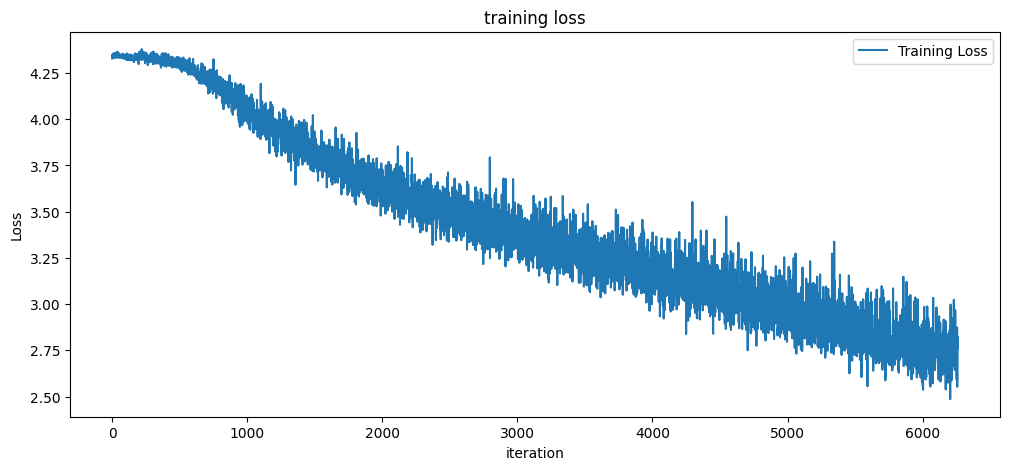

In [ ]:
# lossとaccのグラフを描画（推移を折れ線グラフで）
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.title('training loss')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.show()

結果を確認すると，精度としては約30パーセント程度の正解率になっていることが確認できます．<br>
今回の演習では，小規模なBERTモデルを構築して事前学習／ファインチューニングを行いました．<br>
## 課題
- BERTモデルのサイズや事前学習，ファインチューニングについて改良してみましょう